<a href="https://colab.research.google.com/github/possakorn/UoA_DL_2023_3_PK/blob/main/Assignment02_v1.0.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment 2: CNNs for image classification

## Setup: import lib

In [14]:
## section: Data manioulation
import pandas as pd
import numpy as np
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## section: neural network
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Step01: Data exploration

In [16]:
## Download from cifar10
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download = True,
    transform= transforms.Compose([
        # transforms.Resize((64, 64)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

testing_data = datasets.CIFAR10(
    root="data",
    train=False,
    download = True,
    transform= transforms.Compose([
        # transforms.Resize((64, 64)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

Files already downloaded and verified
Files already downloaded and verified


### Exploratory Image analysis

Check Shape of images:  torch.Size([3, 32, 32]) 4
Preview Images with Label : truck
Show of images unique labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


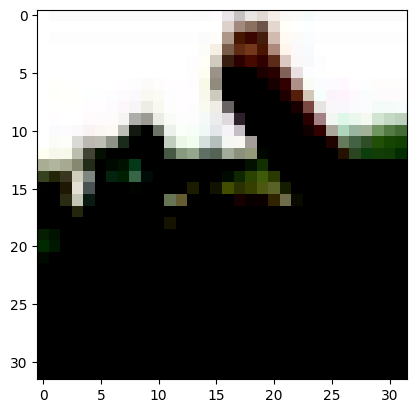

In [17]:
## check shape and labels
img, label = training_data[3]
print("Check Shape of images: ",img.shape,label)

def display_img(img,label):
  print(f"Preview Images with Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

#Show all labels
classes = training_data.classes
print("Show of images unique labels: ",classes)

### Tranforms to Dataloader

In [18]:
batch_size = 32
## apply the dataloader
torch.manual_seed(0)
trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory = True
    )

testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory = True
    )

### Review the Batch fig and size

torch.Size([32, 3, 32, 32])


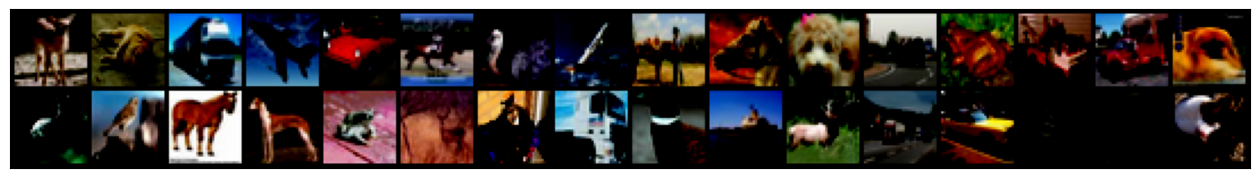

In [19]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

## show the batch fig
show_batch(trainloader)

## print the size
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

## Base Model Functions For Image Classification

In [20]:
## adding the progress bar
import time
from tqdm import tqdm
import gc

def reset_memory():
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def train_network(model, optimizer, criterion, trainloader, testloader, num_epochs, seed=1311):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    set_seed(seed)  # Set the seed
    print('Using device:', device,"with seed: ",seed)
    print()



    # create set to collect the output
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # get the input and output
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward feed
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

            # Then clean the cache
            torch.cuda.empty_cache()
            # then collect the garbage

        epoch_loss = running_loss / total_train
        epoch_acc = correct_train.double() / total_train
        train_loss.append(epoch_loss)
        train_accuracy.append(int(100 * epoch_acc))

        # Validation
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader, desc=f'Epoch {epoch+1}/{num_epochs} Testing'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)

        epoch_test_loss = running_test_loss / total_test
        test_loss.append(epoch_test_loss)
        test_accuracy.append(int(100 * correct_test.double() / total_test))

        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {100 * epoch_acc:.2f}%, '
              f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {100 * correct_test.double() / total_test:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')

    reset_memory()

    return train_loss, train_accuracy, test_loss, test_accuracy

## Initialize network

### network: workshop CNN

In [21]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### network: SimpleCNN

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### network: Alexnet

In [23]:
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=10):
#         super(AlexNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
#             nn.BatchNorm2d(96),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.fc = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(9216, 4096),
#             nn.ReLU())
#         self.fc1 = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU())
#         self.fc2= nn.Sequential(
#             nn.Linear(4096, num_classes))

#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         out = out.reshape(out.size(0), -1)
#         out = self.fc(out)
#         out = self.fc1(out)
#         out = self.fc2(out)
#         return out

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### network: ResNet18

In [24]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## Train the network

In [25]:
def plot_loss(train_loss, val_loss):
    """ Plot the history of losses"""
    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show();




def plot_acc(train_acc, val_acc):
    """ Plot the accuracies in each epoch"""
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show();

results = []

### Train the network - net

Using device: cuda with seed:  1311



Epoch 1/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 87.81it/s] 


Epoch 1/10, Train Loss: 2.2147, Train Acc: 17.36%, Test Loss: 1.9513, Test Acc: 29.73%, Time: 20.77s


Epoch 2/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 112.97it/s]


Epoch 2/10, Train Loss: 1.7651, Train Acc: 34.85%, Test Loss: 1.6389, Test Acc: 40.00%, Time: 19.85s


Epoch 3/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 94.79it/s]


Epoch 3/10, Train Loss: 1.5696, Train Acc: 42.38%, Test Loss: 1.4842, Test Acc: 45.66%, Time: 29.02s


Epoch 4/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 113.69it/s]


Epoch 4/10, Train Loss: 1.4643, Train Acc: 46.76%, Test Loss: 1.4086, Test Acc: 48.86%, Time: 21.50s


Epoch 5/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 105.96it/s]


Epoch 5/10, Train Loss: 1.3884, Train Acc: 49.67%, Test Loss: 1.3437, Test Acc: 51.18%, Time: 20.57s


Epoch 6/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 91.04it/s]


Epoch 6/10, Train Loss: 1.3214, Train Acc: 52.43%, Test Loss: 1.3410, Test Acc: 51.26%, Time: 20.51s


Epoch 7/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 120.76it/s]


Epoch 7/10, Train Loss: 1.2645, Train Acc: 54.49%, Test Loss: 1.2679, Test Acc: 53.87%, Time: 20.29s


Epoch 8/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.36it/s]


Epoch 8/10, Train Loss: 1.2153, Train Acc: 56.33%, Test Loss: 1.2127, Test Acc: 56.67%, Time: 20.25s


Epoch 9/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.71it/s]


Epoch 9/10, Train Loss: 1.1721, Train Acc: 58.29%, Test Loss: 1.1779, Test Acc: 57.89%, Time: 18.99s


Epoch 10/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 118.42it/s]


Epoch 10/10, Train Loss: 1.1308, Train Acc: 59.69%, Test Loss: 1.1820, Test Acc: 58.29%, Time: 19.45s


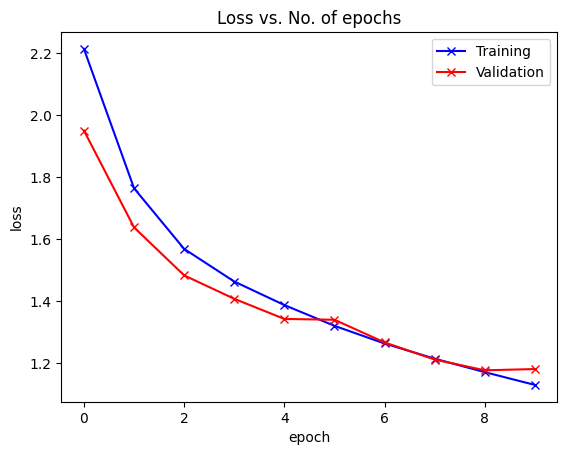

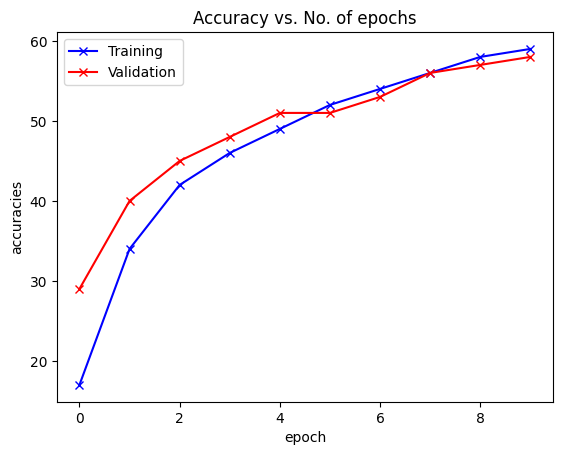

In [26]:
import torch.optim as optim

net = Net().to(device)
model = net
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

net_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(net_results[0], net_results[2])
plot_acc(net_results[1], net_results[3])

# save the model info
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Train the network - simpleCNN

Using device: cuda with seed:  1311



Epoch 1/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 116.39it/s]


Epoch 1/10, Train Loss: 2.0889, Train Acc: 23.41%, Test Loss: 1.7717, Test Acc: 36.45%, Time: 24.37s


Epoch 2/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.95it/s]


Epoch 2/10, Train Loss: 1.5954, Train Acc: 42.13%, Test Loss: 1.4479, Test Acc: 47.59%, Time: 24.29s


Epoch 3/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 116.68it/s]


Epoch 3/10, Train Loss: 1.3814, Train Acc: 50.13%, Test Loss: 1.2740, Test Acc: 53.83%, Time: 24.56s


Epoch 4/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.35it/s]


Epoch 4/10, Train Loss: 1.2512, Train Acc: 55.04%, Test Loss: 1.1845, Test Acc: 57.55%, Time: 24.58s


Epoch 5/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 113.70it/s]


Epoch 5/10, Train Loss: 1.1404, Train Acc: 59.63%, Test Loss: 1.0921, Test Acc: 61.20%, Time: 24.49s


Epoch 6/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 113.03it/s]


Epoch 6/10, Train Loss: 1.0373, Train Acc: 63.51%, Test Loss: 1.0257, Test Acc: 64.21%, Time: 24.54s


Epoch 7/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.92it/s]


Epoch 7/10, Train Loss: 0.9485, Train Acc: 66.83%, Test Loss: 0.9555, Test Acc: 66.68%, Time: 24.62s


Epoch 8/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.38it/s]


Epoch 8/10, Train Loss: 0.8718, Train Acc: 69.64%, Test Loss: 0.9135, Test Acc: 68.06%, Time: 24.61s


Epoch 9/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.51it/s]


Epoch 9/10, Train Loss: 0.8052, Train Acc: 72.12%, Test Loss: 0.8518, Test Acc: 70.17%, Time: 24.50s


Epoch 10/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.97it/s]


Epoch 10/10, Train Loss: 0.7455, Train Acc: 74.24%, Test Loss: 0.8284, Test Acc: 71.35%, Time: 24.54s


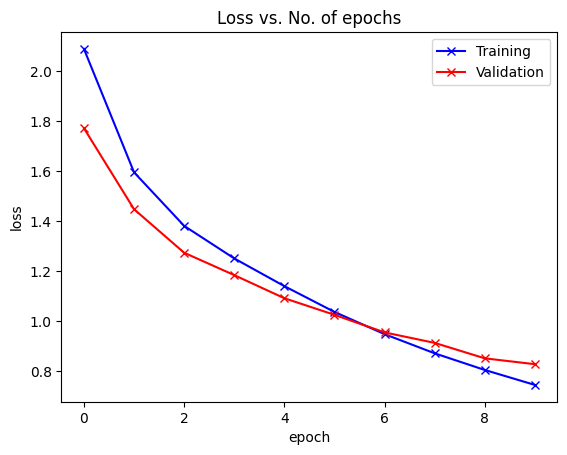

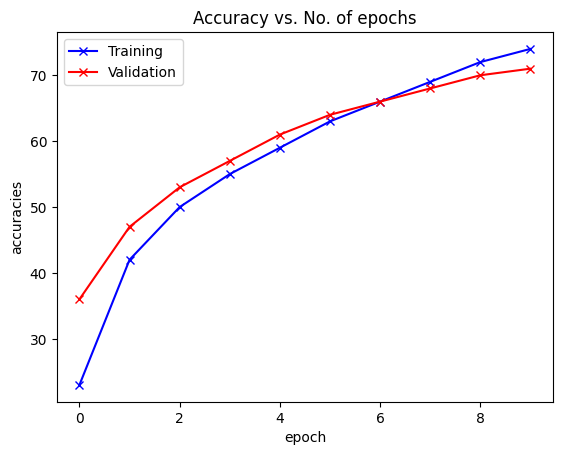

In [27]:
import torch.optim as optim

simplecnn = SimpleCNN().to(device)
model = simplecnn
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

simplecnn_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(simplecnn_results[0], simplecnn_results[2])
plot_acc(simplecnn_results[1], simplecnn_results[3])

# save the model info
PATH = './cifar_simplecnn.pth'
torch.save(simplecnn.state_dict(), PATH)

### Train the network - Alexnet

Using device: cuda with seed:  1311



Epoch 1/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 81.06it/s]


Epoch 1/10, Train Loss: 2.3025, Train Acc: 10.19%, Test Loss: 2.3017, Test Acc: 12.27%, Time: 43.93s


Epoch 2/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.66it/s]


Epoch 2/10, Train Loss: 2.2999, Train Acc: 12.27%, Test Loss: 2.2888, Test Acc: 19.79%, Time: 43.43s


Epoch 3/10 Testing: 100%|██████████| 313/313 [00:04<00:00, 75.06it/s]


Epoch 3/10, Train Loss: 2.0155, Train Acc: 25.02%, Test Loss: 1.7281, Test Acc: 35.06%, Time: 44.27s


Epoch 4/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 90.17it/s]


Epoch 4/10, Train Loss: 1.6714, Train Acc: 37.06%, Test Loss: 1.5284, Test Acc: 42.82%, Time: 43.49s


Epoch 5/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 86.03it/s]


Epoch 5/10, Train Loss: 1.5170, Train Acc: 43.14%, Test Loss: 1.4138, Test Acc: 46.41%, Time: 43.78s


Epoch 6/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 91.24it/s]


Epoch 6/10, Train Loss: 1.3785, Train Acc: 48.68%, Test Loss: 1.3168, Test Acc: 51.77%, Time: 43.31s


Epoch 7/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 91.04it/s]


Epoch 7/10, Train Loss: 1.2608, Train Acc: 53.50%, Test Loss: 1.1851, Test Acc: 56.72%, Time: 43.99s


Epoch 8/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 88.25it/s]


Epoch 8/10, Train Loss: 1.1516, Train Acc: 57.80%, Test Loss: 1.1229, Test Acc: 59.48%, Time: 43.49s


Epoch 9/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.75it/s]


Epoch 9/10, Train Loss: 1.0665, Train Acc: 61.11%, Test Loss: 1.0336, Test Acc: 62.88%, Time: 43.50s


Epoch 10/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.26it/s]


Epoch 10/10, Train Loss: 0.9903, Train Acc: 63.95%, Test Loss: 0.9577, Test Acc: 65.77%, Time: 43.99s


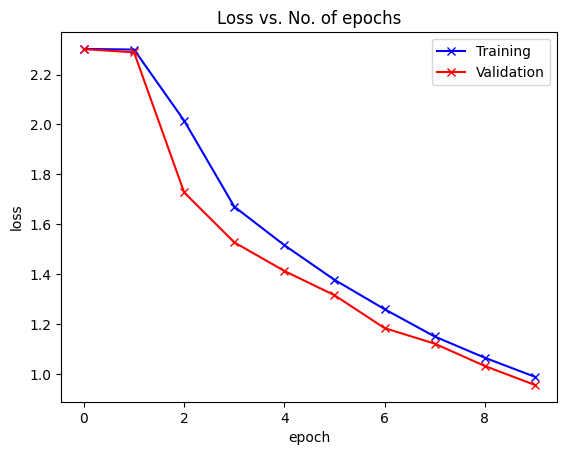

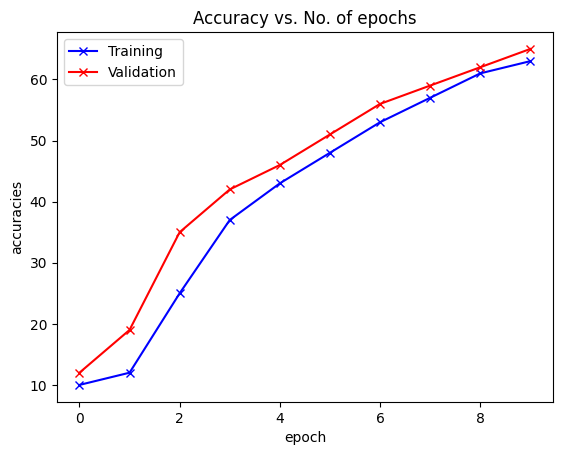

In [28]:
import torch.optim as optim

alexnet = AlexNet().to(device)
model = alexnet
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

alexnet_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(alexnet_results[0], alexnet_results[2])
plot_acc(alexnet_results[1], alexnet_results[3])

# save the model info
PATH = './cifar_alexnet.pth'
torch.save(alexnet.state_dict(), PATH)

### Train the network - Resnet18

Using device: cuda with seed:  1311



Epoch 1/10 Testing: 100%|██████████| 313/313 [00:05<00:00, 60.56it/s]


Epoch 1/10, Train Loss: 1.2717, Train Acc: 53.84%, Test Loss: 0.9611, Test Acc: 65.83%, Time: 74.54s


Epoch 2/10 Testing: 100%|██████████| 313/313 [00:05<00:00, 61.99it/s]


Epoch 2/10, Train Loss: 0.7854, Train Acc: 72.34%, Test Loss: 0.7392, Test Acc: 73.82%, Time: 73.85s


Epoch 3/10 Testing: 100%|██████████| 313/313 [00:05<00:00, 61.42it/s]


Epoch 3/10, Train Loss: 0.5518, Train Acc: 80.86%, Test Loss: 0.6230, Test Acc: 78.14%, Time: 74.14s


Epoch 4/10 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.17it/s]


Epoch 4/10, Train Loss: 0.3884, Train Acc: 86.47%, Test Loss: 0.7324, Test Acc: 76.21%, Time: 73.96s


Epoch 5/10 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.76it/s]


Epoch 5/10, Train Loss: 0.2502, Train Acc: 91.36%, Test Loss: 0.7117, Test Acc: 77.52%, Time: 73.93s


Epoch 6/10 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.04it/s]


Epoch 6/10, Train Loss: 0.1672, Train Acc: 94.26%, Test Loss: 0.7719, Test Acc: 77.66%, Time: 74.10s


Epoch 7/10 Testing: 100%|██████████| 313/313 [00:04<00:00, 64.48it/s]


Epoch 7/10, Train Loss: 0.1046, Train Acc: 96.53%, Test Loss: 0.7884, Test Acc: 78.90%, Time: 74.50s


Epoch 8/10 Testing: 100%|██████████| 313/313 [00:04<00:00, 64.27it/s]


Epoch 8/10, Train Loss: 0.0808, Train Acc: 97.27%, Test Loss: 1.0306, Test Acc: 75.89%, Time: 74.83s


Epoch 9/10 Testing: 100%|██████████| 313/313 [00:05<00:00, 61.51it/s]


Epoch 9/10, Train Loss: 0.0498, Train Acc: 98.43%, Test Loss: 0.8087, Test Acc: 80.10%, Time: 75.18s


Epoch 10/10 Testing: 100%|██████████| 313/313 [00:05<00:00, 58.71it/s]


Epoch 10/10, Train Loss: 0.0327, Train Acc: 98.97%, Test Loss: 0.8001, Test Acc: 80.55%, Time: 75.50s


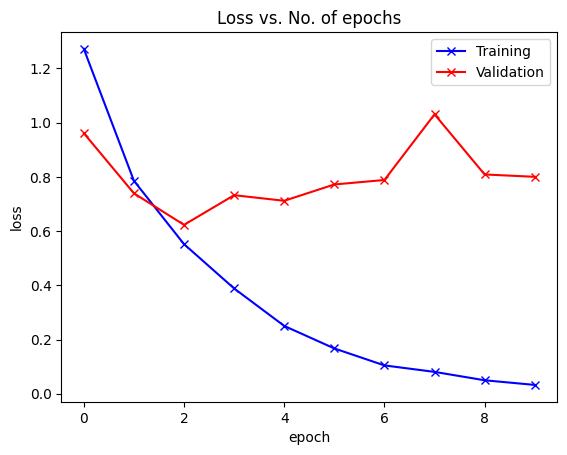

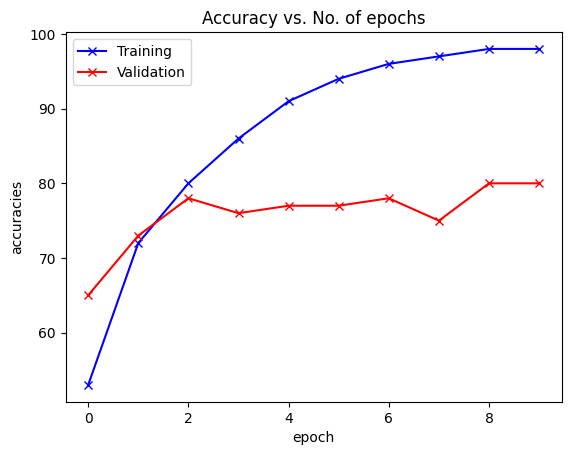

In [29]:
import torch.optim as optim

resnet18 = ResNet18().to(device)
model = resnet18
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

resnet18_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet18_results[0], resnet18_results[2])
plot_acc(resnet18_results[1], resnet18_results[3])

# save the model info
PATH = './cifar_resnet18.pth'
torch.save(resnet18.state_dict(), PATH)

### Train the network - Resnet34

Using device: cuda with seed:  1311



Epoch 1/10 Testing: 100%|██████████| 313/313 [00:06<00:00, 45.68it/s]


Epoch 1/10, Train Loss: 1.3150, Train Acc: 52.25%, Test Loss: 1.0002, Test Acc: 64.74%, Time: 117.29s


Epoch 2/10 Testing: 100%|██████████| 313/313 [00:07<00:00, 43.81it/s]


Epoch 2/10, Train Loss: 0.7854, Train Acc: 72.37%, Test Loss: 0.7539, Test Acc: 74.18%, Time: 117.59s


Epoch 3/10 Testing: 100%|██████████| 313/313 [00:07<00:00, 42.71it/s]


Epoch 3/10, Train Loss: 0.5536, Train Acc: 81.00%, Test Loss: 0.6051, Test Acc: 79.38%, Time: 117.77s


Epoch 4/10 Testing: 100%|██████████| 313/313 [00:06<00:00, 45.37it/s]


Epoch 4/10, Train Loss: 0.3986, Train Acc: 86.26%, Test Loss: 0.6611, Test Acc: 78.34%, Time: 117.49s


Epoch 5/10 Testing: 100%|██████████| 313/313 [00:07<00:00, 42.67it/s]


Epoch 5/10, Train Loss: 0.2718, Train Acc: 90.56%, Test Loss: 0.7785, Test Acc: 76.50%, Time: 117.64s


Epoch 6/10 Testing: 100%|██████████| 313/313 [00:07<00:00, 42.92it/s]


Epoch 6/10, Train Loss: 0.1891, Train Acc: 93.31%, Test Loss: 0.6988, Test Acc: 79.77%, Time: 118.14s


Epoch 7/10 Testing: 100%|██████████| 313/313 [00:06<00:00, 45.56it/s]


Epoch 7/10, Train Loss: 0.1309, Train Acc: 95.48%, Test Loss: 0.7706, Test Acc: 79.17%, Time: 117.46s


Epoch 8/10 Testing: 100%|██████████| 313/313 [00:07<00:00, 44.29it/s]


Epoch 8/10, Train Loss: 0.0960, Train Acc: 96.70%, Test Loss: 0.7337, Test Acc: 80.90%, Time: 117.94s


Epoch 9/10 Testing: 100%|██████████| 313/313 [00:07<00:00, 43.78it/s]


Epoch 9/10, Train Loss: 0.0721, Train Acc: 97.53%, Test Loss: 0.8463, Test Acc: 80.39%, Time: 118.20s


Epoch 10/10 Testing: 100%|██████████| 313/313 [00:07<00:00, 44.27it/s]


Epoch 10/10, Train Loss: 0.0608, Train Acc: 97.83%, Test Loss: 0.8256, Test Acc: 81.04%, Time: 118.04s


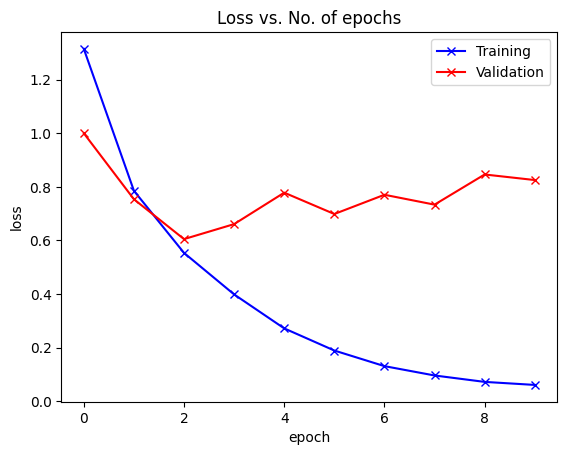

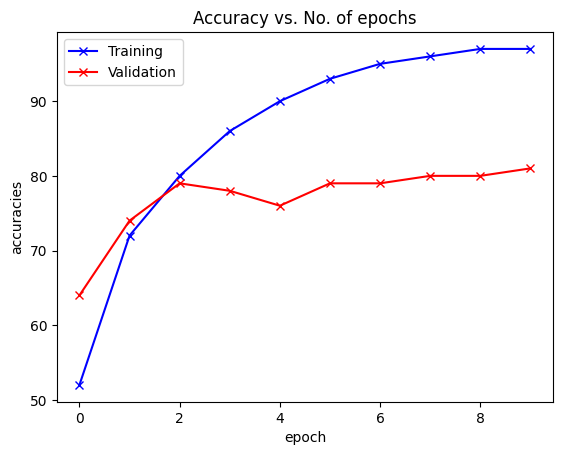

In [30]:
import torch.optim as optim

resnet34 = ResNet34().to(device)
model = resnet34
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

resnet34_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet34_results[0], resnet34_results[2])
plot_acc(resnet34_results[1], resnet34_results[3])

# save the model info
PATH = './cifar_resnet34.pth'
torch.save(resnet34.state_dict(), PATH)

## Test the Model

### Testing data

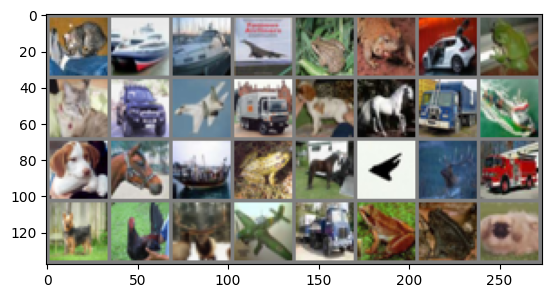

GroundTruth:    cat  ship  ship airplane  frog  frog automobile  frog   cat automobile airplane truck   dog horse truck  ship   dog horse  ship  frog horse airplane  deer truck   dog  bird  deer airplane truck  frog  frog   dog


In [31]:
dataiter = iter(testloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

In [124]:
net = Net()
net.load_state_dict(torch.load('./cifar_net.pth'))

simplecnn = SimpleCNN()
simplecnn.load_state_dict(torch.load('./cifar_simplecnn.pth'))

alexnet = AlexNet()
alexnet.load_state_dict(torch.load('./cifar_alexnet.pth'))

resnet18 = ResNet18()
resnet18.load_state_dict(torch.load('./cifar_resnet18.pth'))

resnet34 = ResNet34()
resnet34.load_state_dict(torch.load('./cifar_resnet34.pth'))

<All keys matched successfully>

In [125]:
def test_set_acc(testloader, model):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
          inputs, labels = data
          # inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)

          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)
          correct += torch.sum(preds == labels.data)
          total += labels.size(0)

          c = (preds == labels).squeeze()
          for i in range(len(labels)):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [133]:
print('Model: net')
test_set_acc(testloader, net)

Model: net
Accuracy of the network on the 10000 test images: 10 %
Accuracy of airplane : 88 %
Accuracy of automobile : 13 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


In [134]:
print('Model: simplecnn')
test_set_acc(testloader, simplecnn)

Model: simplecnn
Accuracy of the network on the 10000 test images: 12 %
Accuracy of airplane : 24 %
Accuracy of automobile :  0 %
Accuracy of  bird : 39 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog : 55 %
Accuracy of horse :  1 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


In [135]:
print('Model: alexnet')
test_set_acc(testloader, alexnet)

Model: alexnet
Accuracy of the network on the 10000 test images: 65 %
Accuracy of airplane : 67 %
Accuracy of automobile : 78 %
Accuracy of  bird : 45 %
Accuracy of   cat : 35 %
Accuracy of  deer : 61 %
Accuracy of   dog : 70 %
Accuracy of  frog : 73 %
Accuracy of horse : 74 %
Accuracy of  ship : 77 %
Accuracy of truck : 74 %


In [136]:
print('Model: resnet18')
test_set_acc(testloader, resnet18)

Model: resnet18
Accuracy of the network on the 10000 test images: 12 %
Accuracy of airplane :  0 %
Accuracy of automobile :  0 %
Accuracy of  bird : 65 %
Accuracy of   cat : 51 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  6 %


In [137]:
print('Model: resnet34')
test_set_acc(testloader, resnet34)

Model: resnet34
Accuracy of the network on the 10000 test images: 11 %
Accuracy of airplane :  0 %
Accuracy of automobile :  0 %
Accuracy of  bird : 76 %
Accuracy of   cat : 32 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  2 %
